#**SC5010: Introduction to Data Analysis Mini Project**

**Group ID:** 8

**Group Member:**
1. Theodore Amadeo Argasetya Atmadja (U2320581F)
2. Timothy Louis Barus (U2320344D)
3. Wilsen Chandra Putra (U2120080E)
---

##**A. Problem Statement**
- **Title:**   
 *Predicting the Presence of Heart Disease*
- **Objective:**   
 To develop a machine learning model that able accurately predict the presence or absence of heart disease in patients based on a clinical attributes.
- **Motivation:**   
 Cardiovascular diseases are one of the leading causes of death globally. Early diagnosis and prevention are key to improving patient outcomes. Leveraging machine learning to analyze clinical data can assist healthcare professionals in making timely and accurate diagnoses. The Cleveland database, being the most used and reliable subset among the heart disease datasets, provides a practical foundation for building predictive models that could potentially be applied in real-world clinical settings.
- **Research Questions:**   
1.   Can a machine learning model accurately classify patients as having or not having heart disease based on the dataset?
2. Which machine learning algorithm provides the best performance for this classification task?
3. What are the most significant clinical features contributing to the prediction of heart disease in this dataset?
---

## **B. Data Preprocessing**
Steps taken in this part:
1.   Ensure full numerical dtypes
2.   Fill NaN values with Naive Bayes
3.   Augment using Z-score augmentation and light mixup
4.   Encode using Autoencoder with PyTorch to denoise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from io import StringIO
import requests
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a function to load data from url
def load_data_from_url (url, column_names, source_name) :
  try:
    response = requests.get(url)
    if response.status_code == 200:
      data = response.text
      df = pd.read_csv(StringIO(data), header=None, names=column_names, na_values= '?')
      df['source_name'] = source_name
      print (f"Successfully loaded data {source_name} data: {df.shape[0]} records")
      return df
    else:
      print(f"Failed to fetch data from {source_name}. Status code: {response.status_code}")
      return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

In [3]:
# Dataset URL
urls = {
        'cleveland': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
        'hungarian': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data',
        'switzerland': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data',
        'va': 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'
}

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Load data into separate DataFrames
dataframes = {}

for source_name, url in urls.items():
    df = pd.read_csv(url, names=column_names, na_values='?')
    dataframes[source_name] = df

cleveland_df = dataframes['cleveland']
hungarian_df = dataframes['hungarian']
switzerland_df = dataframes['switzerland']
va_df = dataframes['va']

In [4]:
cleveland_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:
hungarian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  num       294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [6]:
switzerland_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       123 non-null    int64  
 1   sex       123 non-null    int64  
 2   cp        123 non-null    int64  
 3   trestbps  121 non-null    float64
 4   chol      123 non-null    int64  
 5   fbs       48 non-null     float64
 6   restecg   122 non-null    float64
 7   thalach   122 non-null    float64
 8   exang     122 non-null    float64
 9   oldpeak   117 non-null    float64
 10  slope     106 non-null    float64
 11  ca        5 non-null      float64
 12  thal      71 non-null     float64
 13  num       123 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 13.6 KB


In [7]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       200 non-null    int64  
 1   sex       200 non-null    int64  
 2   cp        200 non-null    int64  
 3   trestbps  144 non-null    float64
 4   chol      193 non-null    float64
 5   fbs       193 non-null    float64
 6   restecg   200 non-null    int64  
 7   thalach   147 non-null    float64
 8   exang     147 non-null    float64
 9   oldpeak   144 non-null    float64
 10  slope     98 non-null     float64
 11  ca        2 non-null      float64
 12  thal      34 non-null     float64
 13  num       200 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 22.0 KB


> Based on this observation, we decide not to combine the dataset and only proceed with Cleveland dataset. Since we believe that the insufficient data for the 'ca' attribute in the Hungarian, Switzerland, and Vatican datasets could introduce bias into the combined dataset if we attempt data augmentation. As a result, including these datasets may disproportionately skew the model toward patterns in the Cleveland dataset.

### **Attributes Used in the Cleveland Dataset**

| No. | Variable Name | Type         | Description                                                                 |
|-----|---------------|--------------|-----------------------------------------------------------------------------|
| 1   | age           | Numerical      | Age in years                                                                |
| 2   | sex           | Categorical  | Sex (1 = male, 0 = female)                                                  |
| 3   | cp            | Categorical  | Chest pain type                                                             |
| 4   | trestbps      | Numerical      | Resting blood pressure (in mm Hg on admission to the hospital)             |
| 5   | chol          | Numerical      | Serum cholesterol in mg/dl                                                  |
| 6   | fbs           | Categorical  | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)                       |
| 7   | restecg       | Categorical  | Resting electrocardiographic results                                       |
| 8   | thalach       | Numerical      | Maximum heart rate achieved                                                 |
| 9   | exang         | Categorical  | Exercise-induced angina (1 = yes, 0 = no)                                   |
| 10  | oldpeak       | Numerical        | ST depression induced by exercise relative to rest                          |
| 11  | slope         | Categorical  | Slope of the peak exercise ST segment                                       |
| 12  | ca            | Categorical      | Number of major vessels (0–3) colored by fluoroscopy                        |
| 13  | thal          | Categorical  | 3 = normal, 6 = fixed defect, 7 = reversible defect                         |
| 14  | num           | Categorical      | Diagnosis of heart disease (0 = no disease, 1–4 = increasing severity)       |


In [8]:
# Function to fill the missing values by using Naive Bayes
def fill_na_with_naive_bayes(df, target_column, other_column_with_missing_values=None):
    missing_target_rows = df[target_column].isna()

    if other_column_with_missing_values:
        df_train = df[~df[other_column_with_missing_values].isna() & ~df[target_column].isna()]
    else:
        df_train = df[~df[target_column].isna()]

    train_data = df_train
    test_data = df[missing_target_rows]

    if train_data.empty:
        print(f"Skipping {target_column} because there are no rows with complete data.")
        return df

    features = df.drop(columns=[target_column]).columns
    X_train = train_data[features]
    y_train = train_data[target_column]
    X_test = test_data[features]

    model = GaussianNB()
    model.fit(X_train, y_train)

    predicted_values = model.predict(X_test)

    for idx, predicted_value in zip(test_data.index, predicted_values):
        old_value = df.at[idx, target_column]
        df.at[idx, target_column] = predicted_value
        print(f"Row {idx}    before: {old_value}    after: {predicted_value}")

    return df

In [9]:
cleveland_df = fill_na_with_naive_bayes(cleveland_df, 'thal', other_column_with_missing_values='ca')

Row 87    before: nan    after: 3.0
Row 266    before: nan    after: 7.0


In [10]:
cleveland_df = fill_na_with_naive_bayes(cleveland_df, 'ca', other_column_with_missing_values='thal')

Row 166    before: nan    after: 0.0
Row 192    before: nan    after: 1.0
Row 287    before: nan    after: 0.0
Row 302    before: nan    after: 0.0


In [11]:
cleveland_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [12]:
# Check the distribution of heart disease presence
print("\nClass distribution:")
for unique in sorted(cleveland_df ['num'].unique()):
  print(f'Level {unique}, distributed: {cleveland_df[cleveland_df["num"] == unique].shape[0]}')

# Calculate percentages
class_percentages = cleveland_df['num'].value_counts(normalize=True).sort_index() * 100
print("\nClass distribution percentages:")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.2f}%")


Class distribution:
Level 0, distributed: 164
Level 1, distributed: 55
Level 2, distributed: 36
Level 3, distributed: 35
Level 4, distributed: 13

Class distribution percentages:
Class 0: 54.13%
Class 1: 18.15%
Class 2: 11.88%
Class 3: 11.55%
Class 4: 4.29%


In [13]:
# Visualize class distribution
fig = px.histogram(
    data_frame=cleveland_df,
    x='num',
    color='num',
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    title='Class Distribution in Heart Disease Dataset',
    labels={'num': 'Disease Severity (0: None, 1-4: Increasing Severity)', 'count': 'Count'}
)

fig.update_layout(
    xaxis_title='Disease Severity (0: None, 1–4: Increasing Severity)',
    yaxis_title='Count',
    bargap=0.1
)

fig.show()

> Upon examining the current class distribution, it is evident that the dataset is skewed towards level 0, indicating a class imbalance. To mitigate potential bias during model training and improve generalization, we propose applying data resampling techniques to balance the distribution across all target classes.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

X = cleveland_df.drop('num', axis=1)
y = cleveland_df['num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print original class distribution
print("Original training set class distribution:")
print(sorted(Counter(y_train).items()))

# Define the custom sampling strategy
sampling_strategy = {
    0: 164,
    1: 100,
    2: 80,
    3: 80,
    4: 60
}

# Approach: Two-step approach (custom implementation)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_temp, y_temp = smote.fit_resample(X_train_scaled, y_train)

# Clean with Tomek links
tomek = TomekLinks()
X_train_two_step, y_train_two_step = tomek.fit_resample(X_temp, y_temp)
print("\nClass distribution after Two-Step (SMOTE + Tomek):")
print(sorted(Counter(y_train_two_step).items()))

Original training set class distribution:
[(0, 123), (1, 41), (2, 27), (3, 26), (4, 10)]

Class distribution after Two-Step (SMOTE + Tomek):
[(0, 163), (1, 98), (2, 79), (3, 80), (4, 60)]


In [15]:
# Convert the standardized values back to the original scale
X_train_two_step_original_scale = scaler.inverse_transform(X_train_two_step)

# Create the DataFrame with proper column names
X_train_resampled_df = pd.DataFrame(X_train_two_step_original_scale, columns=X.columns)

# Create a Series for the resampled target
y_train_resampled_df = pd.Series(y_train_two_step, name='num')

final_cleveland_df = X_train_resampled_df.copy()
final_cleveland_df['num'] = y_train_resampled_df

# Convert the categorical columns into int
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
final_cleveland_df[categorical_columns] = final_cleveland_df[categorical_columns].astype(int)

# Check the statistics
final_cleveland_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,55.046362,0.681250,3.250000,132.475104,251.553315,0.102083,0.935417,146.342746,0.343750,1.399777,1.620833,0.725000,5.229167,1.533333
std,8.439652,0.466478,0.902328,15.743333,52.879714,0.303074,0.948571,20.448651,0.475454,1.248512,0.553960,0.960276,1.857553,1.419714
min,34.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,49.000000,0.000000,3.000000,120.000000,215.077455,0.000000,0.000000,131.331122,0.000000,0.288416,1.000000,0.000000,3.000000,0.000000
50%,56.433226,1.000000,4.000000,130.124958,247.000000,0.000000,1.000000,147.254233,0.000000,1.200000,2.000000,0.000000,6.000000,1.000000
75%,61.062727,1.000000,4.000000,141.074283,282.093131,0.000000,2.000000,162.000000,1.000000,2.205651,2.000000,1.000000,7.000000,3.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [16]:
final_cleveland_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       480 non-null    float64
 1   sex       480 non-null    int64  
 2   cp        480 non-null    int64  
 3   trestbps  480 non-null    float64
 4   chol      480 non-null    float64
 5   fbs       480 non-null    int64  
 6   restecg   480 non-null    int64  
 7   thalach   480 non-null    float64
 8   exang     480 non-null    int64  
 9   oldpeak   480 non-null    float64
 10  slope     480 non-null    int64  
 11  ca        480 non-null    int64  
 12  thal      480 non-null    int64  
 13  num       480 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 52.6 KB


In [17]:
# Count the class distribution
class_counts = final_cleveland_df['num'].value_counts().sort_index().reset_index()
class_counts.columns = ['num', 'count']

# Create pie chart
fig = px.pie(
    data_frame=class_counts,
    names='num',
    values='count',
    color='num',
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    title='Class Distribution After Being Resampled'
)

fig.update_traces(textinfo='percent+label')
fig.show()

In [18]:
final_cleveland_df.sample (20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
414,56.206086,1,4,146.412173,258.877735,0,2,112.076348,1,1.003310,1,0,7,3
288,61.890582,0,1,134.890582,264.120845,0,2,174.000000,0,0.855852,2,1,3,1
369,53.845693,1,4,118.602656,328.117875,0,0,136.404630,1,2.655894,2,1,7,2
410,53.459212,1,4,114.055907,231.699367,0,0,137.356541,0,2.313291,1,1,7,3
467,61.241144,0,4,154.397140,372.409167,0,2,145.205720,0,3.120572,2,3,7,4
297,55.960661,1,4,132.104905,184.249148,0,2,105.655653,1,2.113113,2,0,6,1
236,60.532707,0,3,127.919624,292.424756,0,0,126.680846,0,1.705280,2,1,3,0
9,71.000000,0,4,112.000000,149.000000,0,0,125.000000,0,1.600000,2,0,3,0
402,63.189151,1,3,152.830685,279.395506,0,0,115.584657,1,3.366005,2,1,7,3
257,64.722042,1,4,120.416936,178.042341,0,0,140.972851,0,0.386102,1,0,7,0


> The final preprocessed dataframe has been prepared for subsequent modeling steps. Through targeted augmentation, it substantially improves the representation of minority classes while preserving a realistic class distribution hierarchy (i.e., class 0 > class 1 > others). Furthermore, the strategy deliberately limits synthetic sample generation for class 4 to prevent overfitting and preserve the integrity of the original data, given its limited initial instances.


---



## **C. Exploratory Data Analysis (EDA)**

### 1. Numerical Attributes

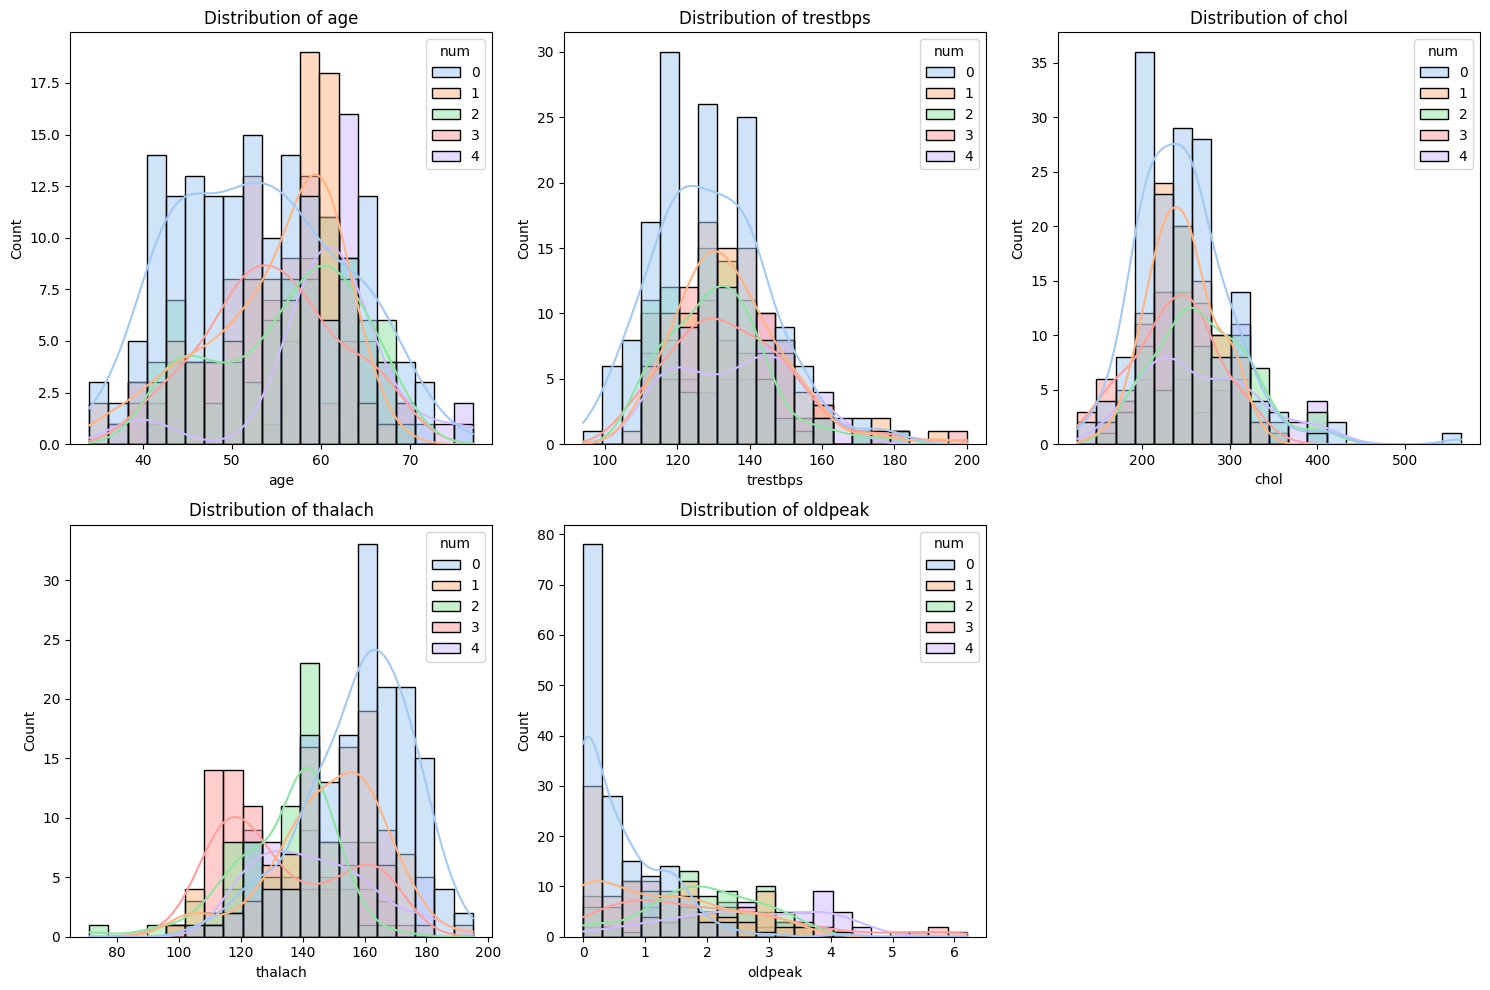

In [19]:
# Check the distribution for numerical attributes
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
  plt.subplot (2, 3, i + 1)
  sns.histplot(data = final_cleveland_df, x=col, hue='num', palette='pastel', bins=20, kde=True)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show ()

Number of outliers in age: 0
Number of outliers in trestbps: 9
Number of outliers in chol: 11
Number of outliers in thalach: 1
Number of outliers in oldpeak: 5


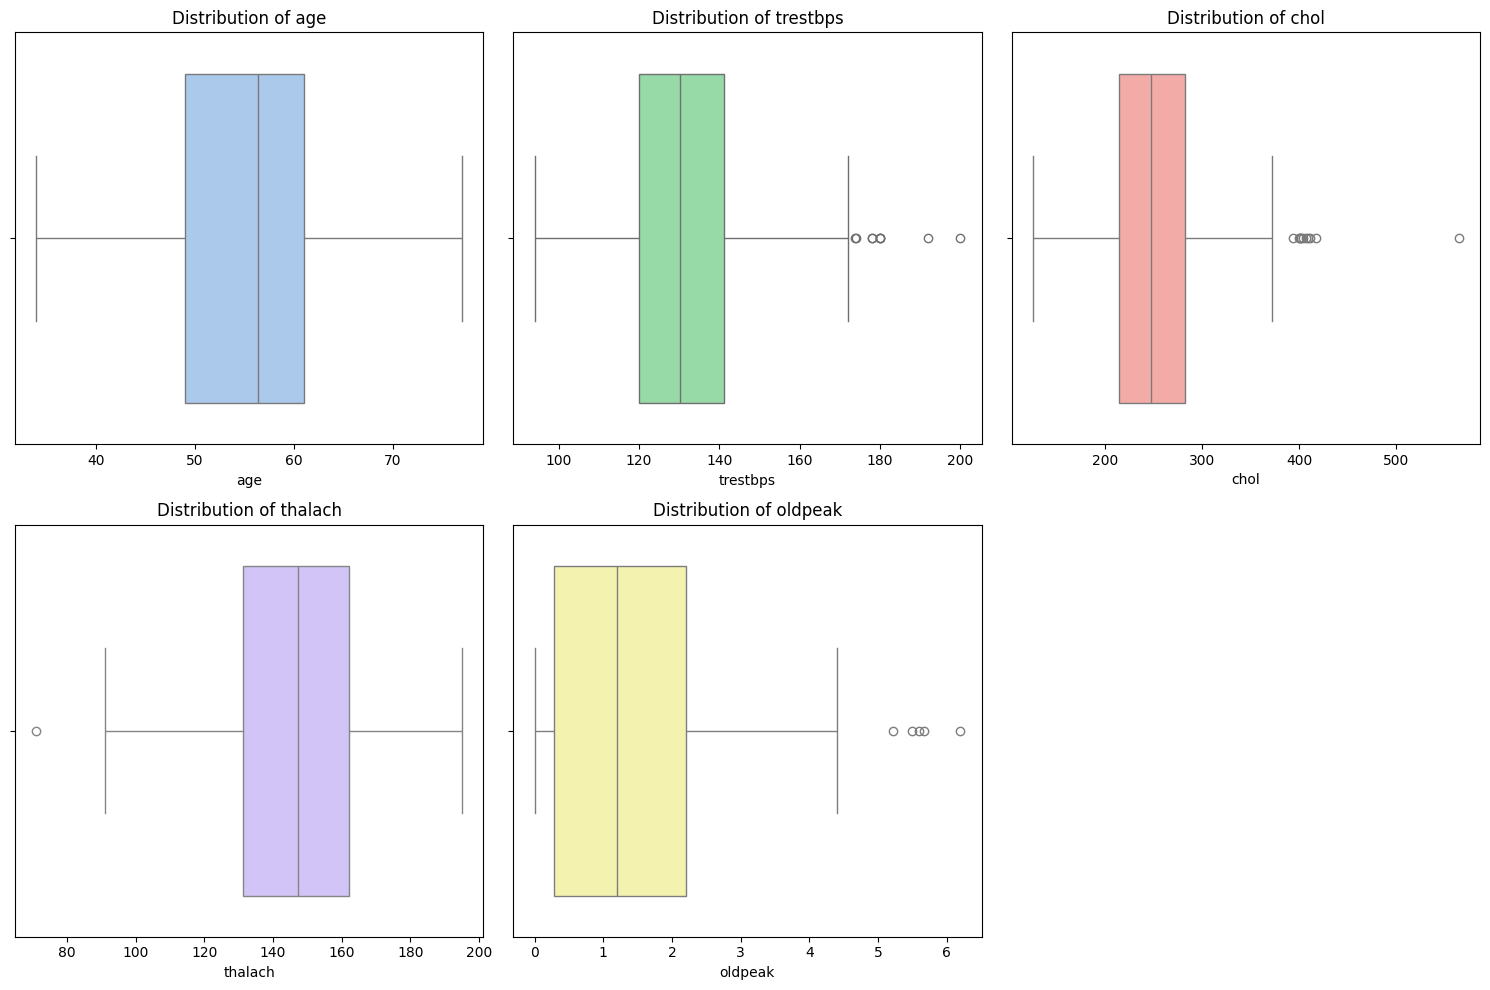

In [20]:
# Check the number of outliers
for col in numerical_columns:
  q1 = final_cleveland_df[col].quantile(0.25)
  q3 = final_cleveland_df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  print(f'Number of outliers in {col}: {final_cleveland_df[(final_cleveland_df[col] < lower_bound) | (final_cleveland_df[col] > upper_bound)].shape[0]}')

# Check the distribution for every attributes by using boxplot
plt.figure(figsize=(15, 10))
color_choice = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
for i, col in enumerate(numerical_columns):
  plt.subplot (2, 3, i + 1)
  sns.boxplot(data = final_cleveland_df, x=col, color=color_choice[i])
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show ()



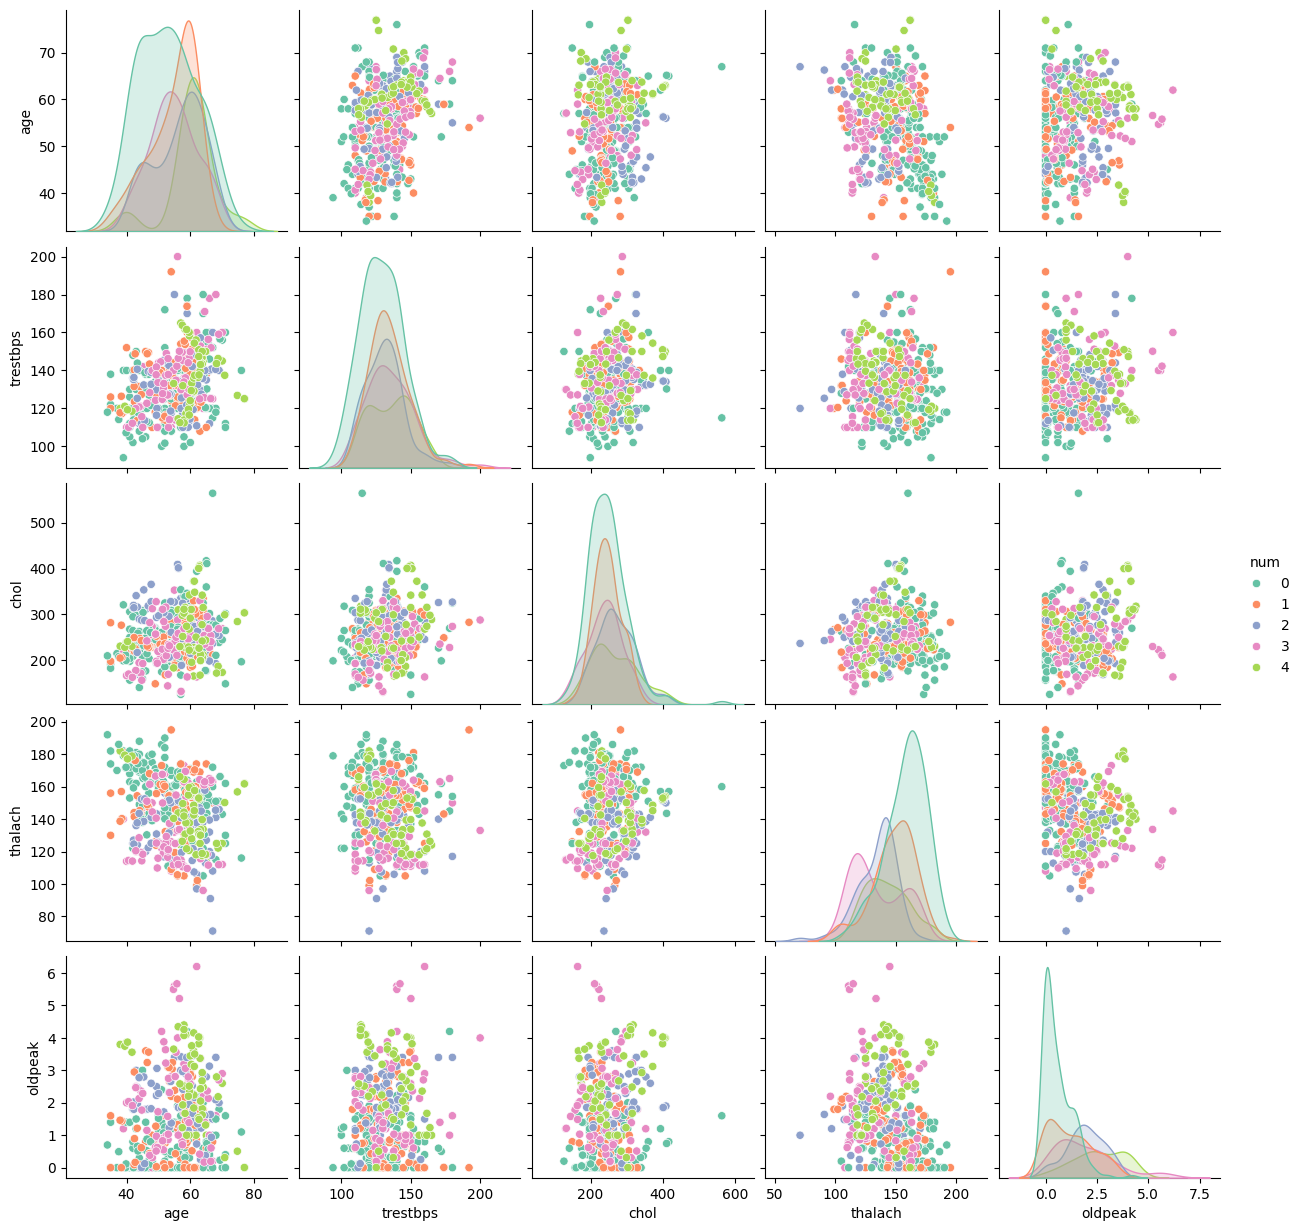

In [21]:
# Check the linearity for the numeric attributes
sns.pairplot(final_cleveland_df, vars=numerical_columns, hue='num', palette='Set2')

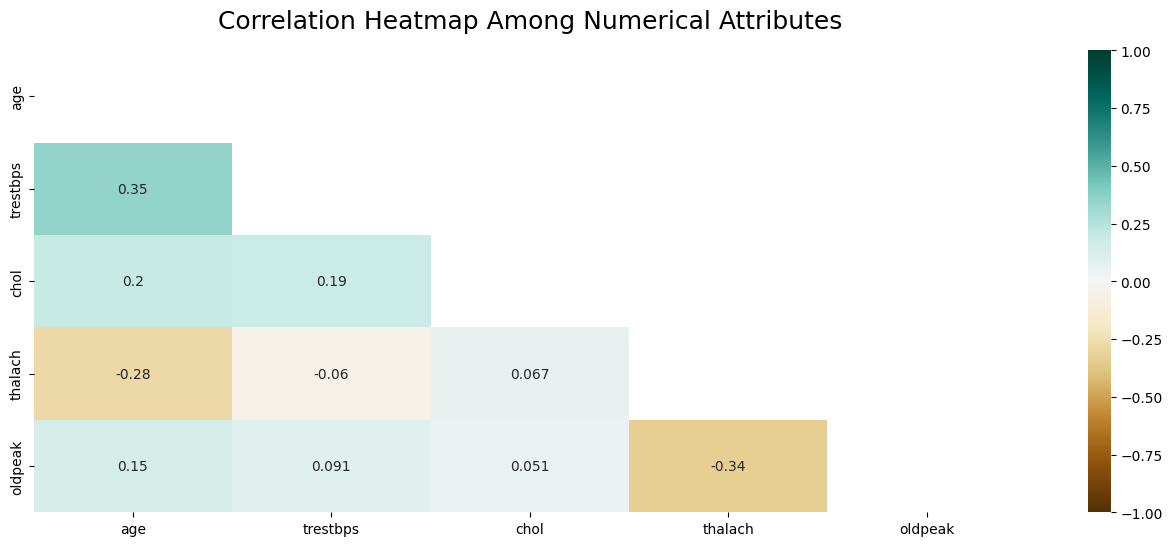

In [22]:
# Check the correlation among the numerical attributes
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(final_cleveland_df[numerical_columns].corr(), dtype=np.bool))
heatmap = sns.heatmap(final_cleveland_df[numerical_columns].corr(), mask = mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Among Numerical Attributes', fontdict={'fontsize':18}, pad=16);

* **What These Plots Tells Us**

*a. Diagonal (Distribution within class)*

| Feature    | Observation |
|------------|-------------|
| `age`      | Class 0 (green) is slightly younger; not highly separable |
| `trestbps` | Similar overlap across classes; slight skew in class 1/2 |
| `chol`     | Heavy overlap → **not a strong discriminative feature** |
| `thalach`  | Class 0 (green) has generally higher heart rates → **possibly useful** |
| `oldpeak`  | Class 0 (green) shows much lower values than other classes → **strong indicator** |

 **`thalach`** and **`oldpeak`** appear to show **some separation by class**

*b. Off-Diagonal (Pairwise relationships by class)*

| Pair                 | Insights |
|----------------------|----------|
| `thalach` vs `age`   | Negative correlation in general; younger patients → higher heart rate |
| `oldpeak` vs `thalach` | Inverse relation; class 0 (green) clusters at high `thalach`, low `oldpeak` |
| Others               | Most other pairs show **high overlap** among classes, implying weak separation |


### 2. Categorical Attributes

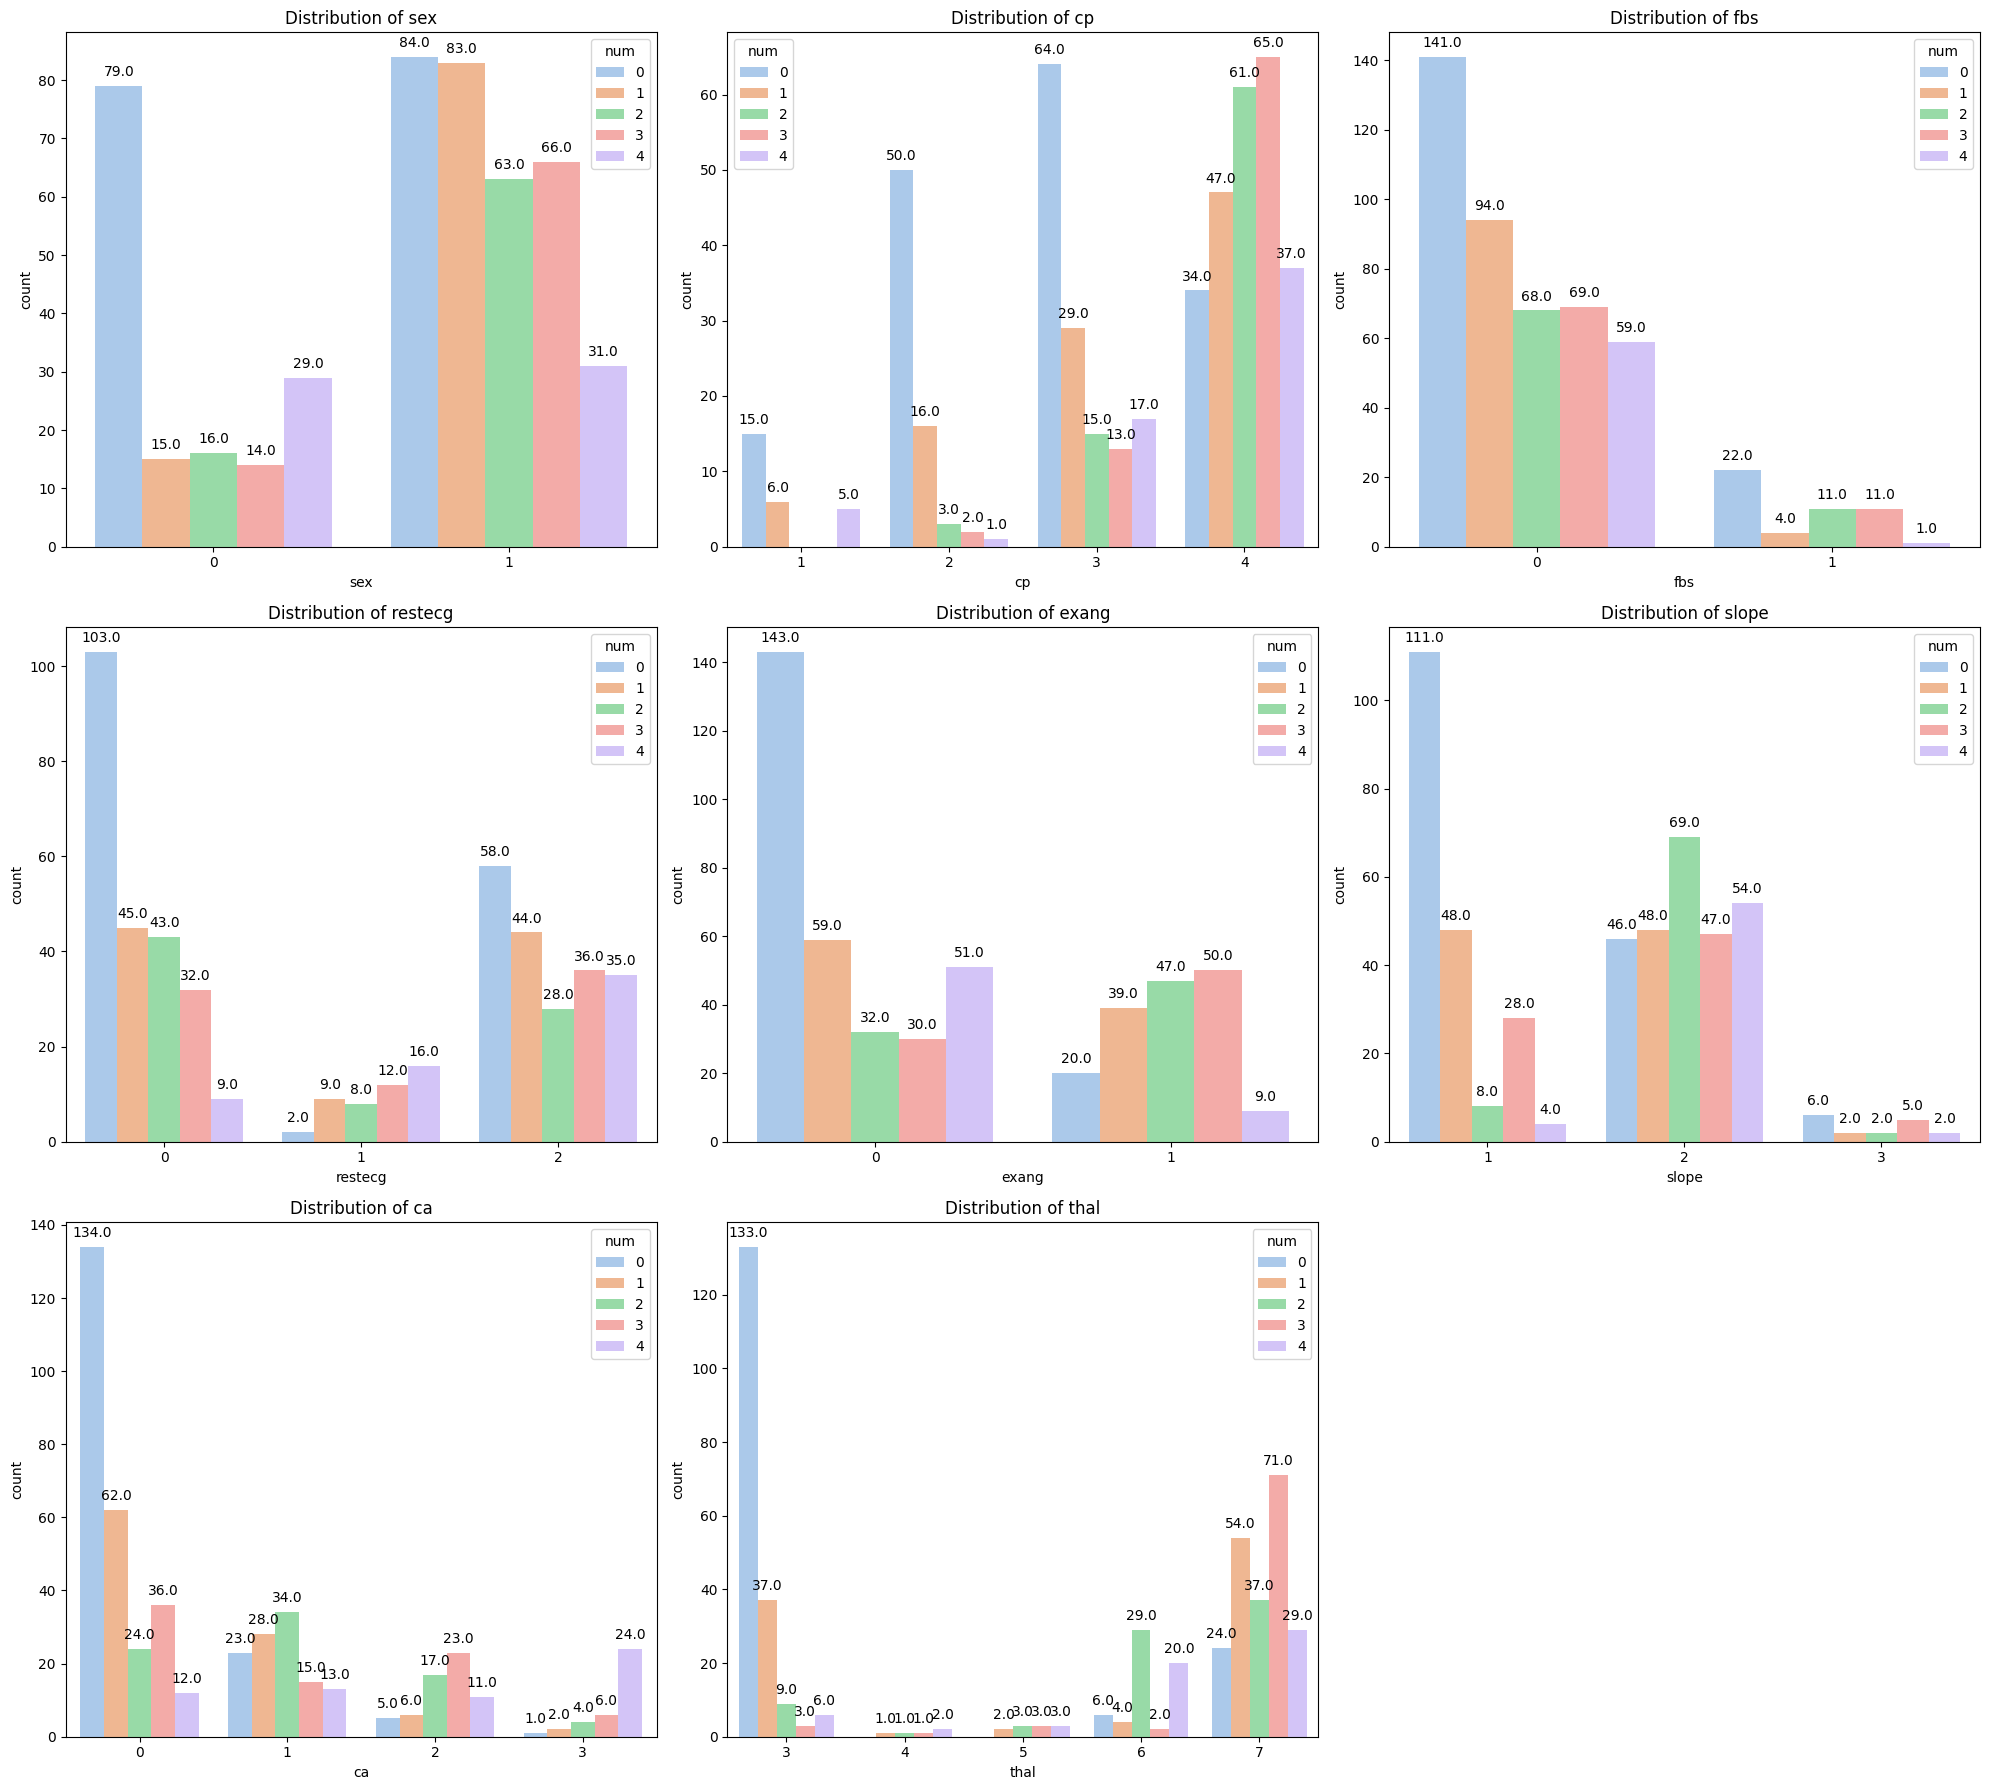

In [43]:
# Check the distribution of each categorical attributes
plt.figure (figsize=(20, 18))

for i, col in enumerate(categorical_columns):
  plt.subplot (3, 3, i + 1)
  order = sorted (final_cleveland_df[col].unique())
  ax = sns.countplot(data = final_cleveland_df, hue = 'num', x=col, palette='pastel', order=order, hue_order = ['0', '1', '2', '3', '4'])
  plt.title(f'Distribution of {col}')

  for p in ax.patches:
    height = p.get_height()
    if height > 0:
      ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show ()


In [47]:
# Check the dependency of each catorical attributes with 'num'

from scipy.stats import chi2_contingency
import pandas as pd

target_col = 'num'

print("Chi-Square Test Results:\n")

for col in categorical_columns:
    # Create contingency table
    ct = pd.crosstab(final_cleveland_df[col], final_cleveland_df[target_col])

    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(ct)

    # Display results
    print(f"Feature: {col}")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p}")

    if p < 0.05:
        print("Statistically significant → likely related to target")
    else:
        print("Not statistically significant → likely independent")
    print("-" * 60)


Chi-Square Test Results:

Feature: sex
Chi-square statistic: 53.06
Degrees of freedom: 4
p-value: 8.264440084467011e-11
Statistically significant → likely related to target
------------------------------------------------------------
Feature: cp
Chi-square statistic: 131.82
Degrees of freedom: 12
p-value: 2.6615796382504024e-22
Statistically significant → likely related to target
------------------------------------------------------------
Feature: fbs
Chi-square statistic: 13.00
Degrees of freedom: 4
p-value: 0.01129131012294462
Statistically significant → likely related to target
------------------------------------------------------------
Feature: restecg
Chi-square statistic: 61.64
Degrees of freedom: 8
p-value: 2.2214875655554632e-10
Statistically significant → likely related to target
------------------------------------------------------------
Feature: exang
Chi-square statistic: 96.72
Degrees of freedom: 4
p-value: 4.918557170480984e-20
Statistically significant → likely relate

In [49]:
# Check how strong the relationship is based on Cramér's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of your categorical features

print("Cramér's V: Strength of Association with Target (num)\n")

for col in categorical_columns:
    v = cramers_v(final_cleveland_df[col], final_cleveland_df[target_col])
    strength = (
        "Very strong" if v > 0.8 else
        "Strong" if v > 0.6 else
        "Relatively strong" if v > 0.4 else
        "Moderate" if v > 0.2 else
        "Weak" if v > 0.1 else
        "Negligible"
    )
    print(f"{col.ljust(10)} → Cramér’s V = {v:.4f} → {strength}")

Cramér's V: Strength of Association with Target (num)

sex        → Cramér’s V = 0.3200 → Moderate
cp         → Cramér’s V = 0.2893 → Moderate
fbs        → Cramér’s V = 0.1370 → Weak
restecg    → Cramér’s V = 0.2368 → Moderate
exang      → Cramér’s V = 0.4399 → Relatively strong
slope      → Cramér’s V = 0.3412 → Moderate
ca         → Cramér’s V = 0.3630 → Moderate
thal       → Cramér’s V = 0.3792 → Moderate


### **Summary of Categorical Attributes and Their Relationship with Heart Disease Severity**

This section evaluates the association between each categorical feature and the target variable 'num' (heart disease severity), based on:

- Chi-square test of independence (p-value)
- Cramér’s V (association strength)


#### **Categorical Features Overview**

| Feature   | Chi-Square p-value       | Relationship      | Cramér’s V | Strength           |
|-----------|---------------------------|-------------------|------------|---------------------|
| `sex`     | 8.26e-11                  | Significant       | 0.320      | Moderate            |
| `cp`      | 2.66e-22                  | Significant       | 0.289      | Moderate            |
| `fbs`     | 0.0113                    | Significant       | 0.137      | Weak                |
| `restecg` | 2.22e-10                  | Significant       | 0.236      | Moderate            |
| `exang`   | 4.92e-20                  | Significant       | 0.440      | Relatively strong   |
| `slope`   | 4.66e-22                  | Significant       | 0.341      | Moderate            |
| `ca`      | 2.53e-36                  | Significant       | 0.363      | Moderate            |
| `thal`    | 3.28e-52                  | Significant       | 0.379      | Moderate            |



#### **Key Insights**

- All categorical variables show a **statistically significant relationship** with 'num' (p < 0.05).
- The **strongest associations** are found in:
  - `exang` (exercise-induced angina) → **Relatively strong**
  - `thal`, `ca`, `slope` → **Moderate to strong** predictive features
- `fbs` (fasting blood sugar) shows **only weak association**, and may be a **weaker predictor**.

---